Epoch 100/3000, Loss (Train): 0.0459, Loss (Validation): 0.0214
Epoch 200/3000, Loss (Train): 0.0414, Loss (Validation): 0.0154
Epoch 300/3000, Loss (Train): 0.0393, Loss (Validation): 0.0123
Epoch 400/3000, Loss (Train): 0.0381, Loss (Validation): 0.0102
Epoch 500/3000, Loss (Train): 0.0375, Loss (Validation): 0.0093
Epoch 600/3000, Loss (Train): 0.0370, Loss (Validation): 0.0092
Epoch 700/3000, Loss (Train): 0.0366, Loss (Validation): 0.0101
Epoch 800/3000, Loss (Train): 0.0363, Loss (Validation): 0.0114
Epoch 900/3000, Loss (Train): 0.0361, Loss (Validation): 0.0124
Epoch 1000/3000, Loss (Train): 0.0354, Loss (Validation): 0.0177
Epoch 1100/3000, Loss (Train): 0.0262, Loss (Validation): 0.0119
Epoch 1200/3000, Loss (Train): 0.0219, Loss (Validation): 0.0071
Epoch 1300/3000, Loss (Train): 0.0191, Loss (Validation): 0.0043
Epoch 1400/3000, Loss (Train): 0.0168, Loss (Validation): 0.0028
Epoch 1500/3000, Loss (Train): 0.0145, Loss (Validation): 0.0018
Epoch 1600/3000, Loss (Train): 0.0

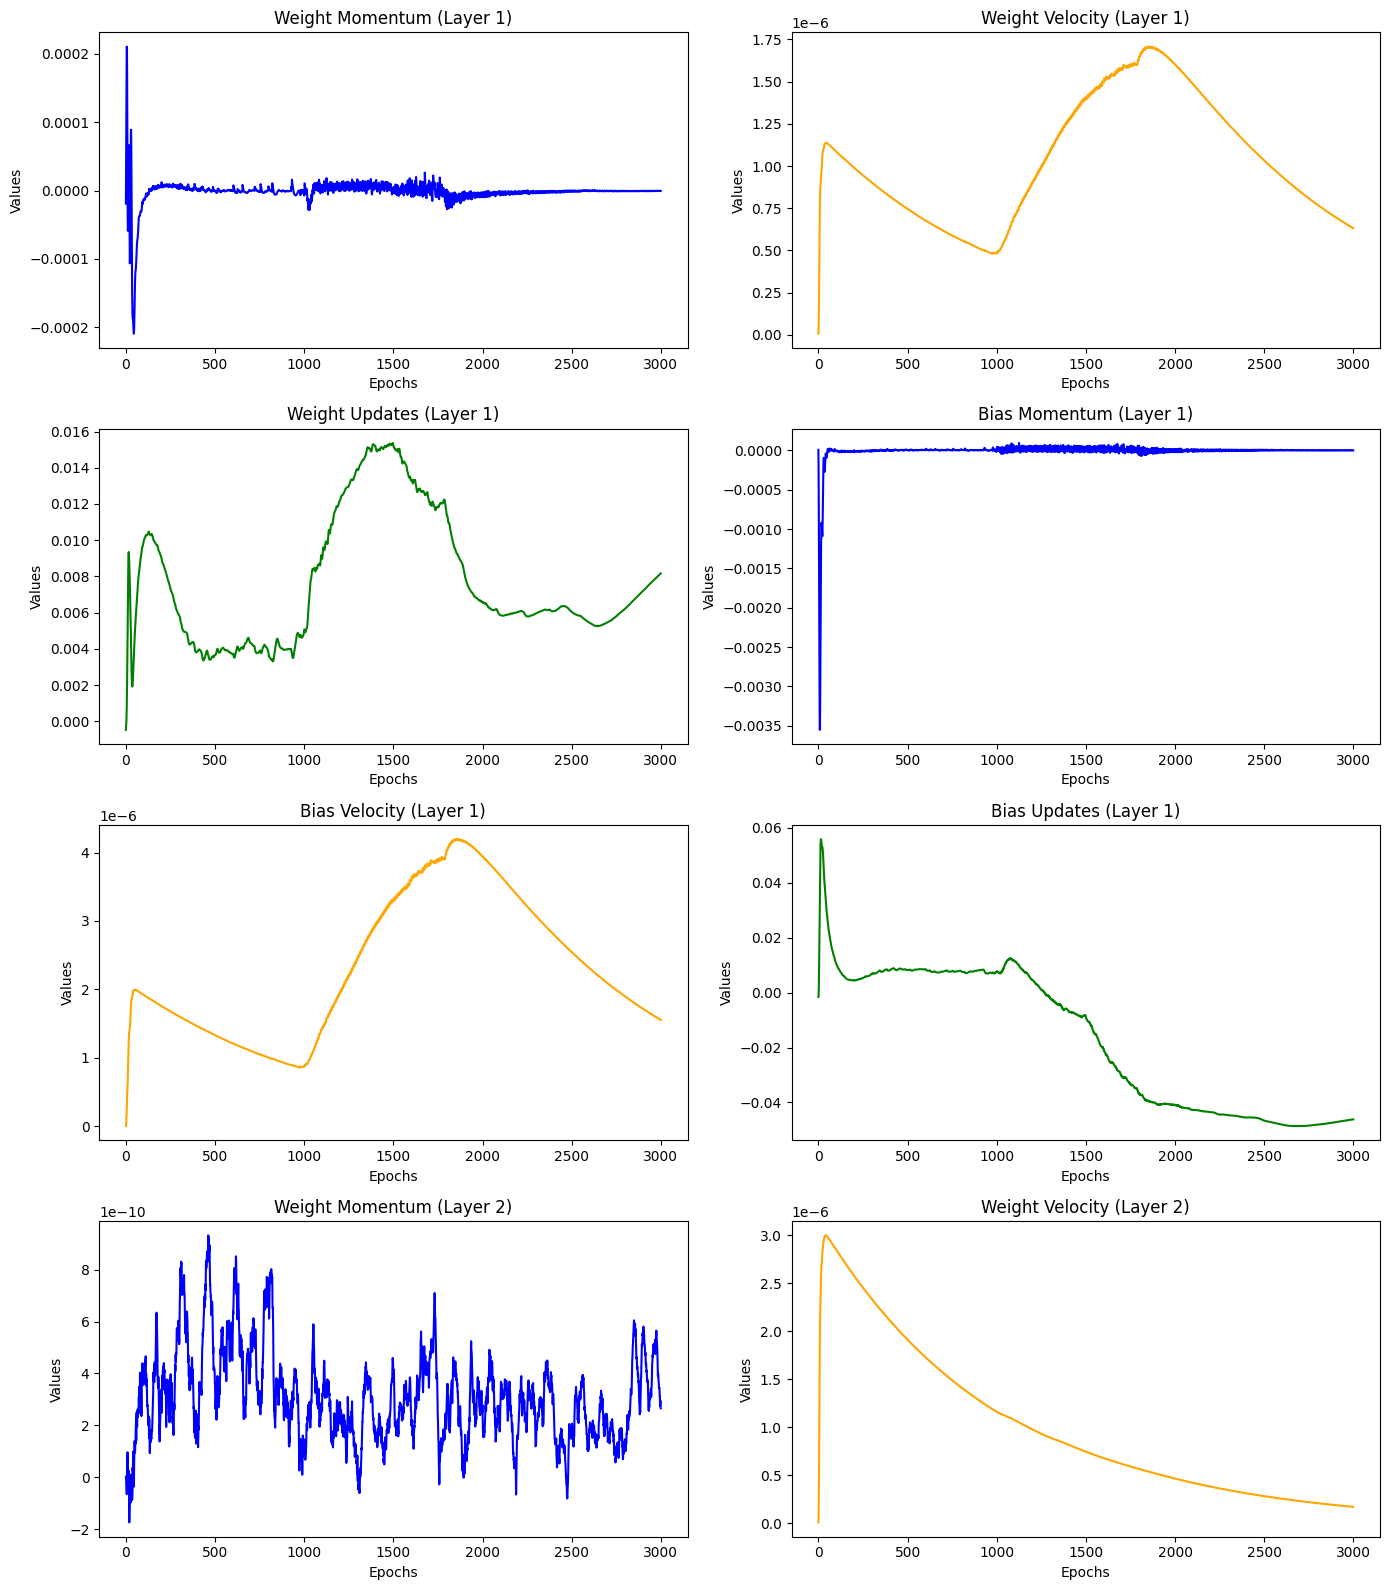

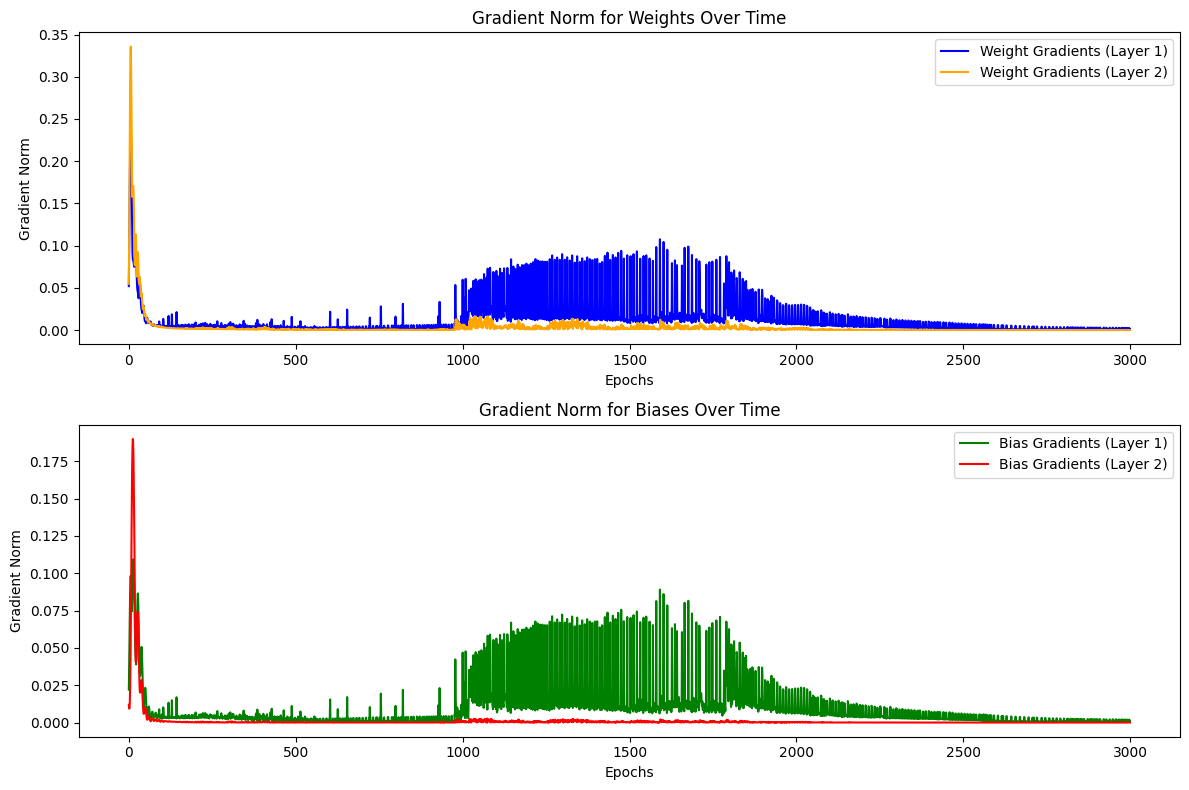

In [9]:
import os
import torch
import matplotlib.pyplot as plt

# Limit to 20 CPUs
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["OPENBLAS_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
os.environ["VECLIB_MAXIMUM_THREADS"] = "20"
os.environ["NUMEXPR_NUM_THREADS"] = "20"

torch.set_num_threads(20)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the Iris dataset
iris = load_iris()
features, target = iris.data, iris.target

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# One-hot encode the target labels
encoder = OneHotEncoder(sparse_output=False)
target = encoder.fit_transform(target.reshape(-1, 1))

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

# Split into train and validation sets
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize weights and biases manually
input_size = 4
hidden_layer_size = 100
output_size = 3

weights_layer1 = torch.randn(input_size, hidden_layer_size, requires_grad=True) * 0.01
biases_layer1 = torch.zeros(hidden_layer_size, requires_grad=True)
weights_layer2 = torch.randn(hidden_layer_size, output_size, requires_grad=True) * 0.01
biases_layer2 = torch.zeros(output_size, requires_grad=True)

# Initialize Adam optimizer variables
momentum_weights_layer1 = torch.zeros_like(weights_layer1)
velocity_weights_layer1 = torch.zeros_like(weights_layer1)
momentum_biases_layer1 = torch.zeros_like(biases_layer1)
velocity_biases_layer1 = torch.zeros_like(biases_layer1)

momentum_weights_layer2 = torch.zeros_like(weights_layer2)
velocity_weights_layer2 = torch.zeros_like(weights_layer2)
momentum_biases_layer2 = torch.zeros_like(biases_layer2)
velocity_biases_layer2 = torch.zeros_like(biases_layer2)

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Custom softmax function
def softmax(logits):
    exp_logits = torch.exp(logits)
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

# Custom cross-entropy loss
def cross_entropy_loss(predicted_output, true_output):
    epsilon = 1e-8
    batch_size = true_output.shape[0]
    log_predictions = -torch.log(predicted_output + epsilon)
    loss = torch.sum(true_output * log_predictions) / batch_size
    return loss

# Forward pass
def forward_pass(features, weights_layer1, biases_layer1, weights_layer2, biases_layer2):
    hidden_layer_input = features.mm(weights_layer1) + biases_layer1
    hidden_layer_output = torch.relu(hidden_layer_input)
    output_layer_input = hidden_layer_output.mm(weights_layer2) + biases_layer2
    predicted_output = softmax(output_layer_input)
    return predicted_output, hidden_layer_output

# Backward pass
def backward_pass(features, predicted_output, true_output, hidden_layer_output, weights_layer2):
    batch_size = true_output.shape[0]
    
    # Gradients for output layer
    gradient_output_layer_input = (predicted_output - true_output) / batch_size
    gradient_weights_layer2 = hidden_layer_output.t().mm(gradient_output_layer_input)
    gradient_biases_layer2 = torch.sum(gradient_output_layer_input, dim=0)
    
    # Gradients for hidden layer
    gradient_hidden_layer_output = gradient_output_layer_input.mm(weights_layer2.t())
    gradient_hidden_layer_input = gradient_hidden_layer_output.clone()
    gradient_hidden_layer_input[hidden_layer_output <= 0] = 0  # derivative of ReLU
    gradient_weights_layer1 = features.t().mm(gradient_hidden_layer_input)
    gradient_biases_layer1 = torch.sum(gradient_hidden_layer_input, dim=0)
    
    return gradient_weights_layer1, gradient_biases_layer1, gradient_weights_layer2, gradient_biases_layer2

# Adam optimizer update
def adam_update(weights, biases, gradient_weights, gradient_biases, momentum_weights, velocity_weights, momentum_biases, velocity_biases, epoch, learning_rate, beta1, beta2, epsilon):
    # Update moment estimates
    momentum_weights = beta1 * momentum_weights + (1 - beta1) * gradient_weights
    velocity_weights = beta2 * velocity_weights + (1 - beta2) * (gradient_weights ** 2)
    momentum_biases = beta1 * momentum_biases + (1 - beta1) * gradient_biases
    velocity_biases = beta2 * velocity_biases + (1 - beta2) * (gradient_biases ** 2)
    
    # Bias correction
    momentum_weights_hat = momentum_weights / (1 - beta1 ** epoch)
    velocity_weights_hat = velocity_weights / (1 - beta2 ** epoch)
    momentum_biases_hat = momentum_biases / (1 - beta1 ** epoch)
    velocity_biases_hat = velocity_biases / (1 - beta2 ** epoch)
    
    # Update weights
    weights.data -= learning_rate * momentum_weights_hat / (torch.sqrt(velocity_weights_hat) + epsilon)
    biases.data -= learning_rate * momentum_biases_hat / (torch.sqrt(velocity_biases_hat) + epsilon)
    
    return momentum_weights, velocity_weights, momentum_biases, velocity_biases

# Training loop with Adam optimizer
def train(features_train, target_train, features_val, target_val, weights_layer1, biases_layer1, weights_layer2, biases_layer2, epochs, learning_rate):
    global momentum_weights_layer1, velocity_weights_layer1, momentum_biases_layer1, velocity_biases_layer1
    global momentum_weights_layer2, velocity_weights_layer2, momentum_biases_layer2, velocity_biases_layer2

    # Lists for storing moment history for visualization (both layers)
    weight1_momentum_history, weight2_momentum_history = [], []
    weight1_velocity_history, weight2_velocity_history = [], []
    weight1_update_history, weight2_update_history = [], []
    bias1_momentum_history, bias2_momentum_history = [], []
    bias1_velocity_history, bias2_velocity_history = [], []
    bias1_update_history, bias2_update_history = [], []

    # Lists for storing gradient history
    weight1_grad_history, weight2_grad_history = [], []
    bias1_grad_history, bias2_grad_history = [], []

    for epoch in range(epochs):
        # Forward pass (training)
        predicted_output_train, hidden_layer_output_train = forward_pass(features_train, weights_layer1, biases_layer1, weights_layer2, biases_layer2)
        
        # Compute training loss
        loss_train = cross_entropy_loss(predicted_output_train, target_train)
        
        # Backward pass (training)
        gradient_weights_layer1, gradient_biases_layer1, gradient_weights_layer2, gradient_biases_layer2 = backward_pass(
            features_train, predicted_output_train, target_train, hidden_layer_output_train, weights_layer2)
        
        # Perform Adam update for Layer 1
        epoch_count = epoch + 1
        momentum_weights_layer1, velocity_weights_layer1, momentum_biases_layer1, velocity_biases_layer1 = adam_update(
            weights_layer1, biases_layer1, gradient_weights_layer1, gradient_biases_layer1, 
            momentum_weights_layer1, velocity_weights_layer1, momentum_biases_layer1, velocity_biases_layer1, 
            epoch_count, learning_rate, beta1, beta2, epsilon)
        
        # Perform Adam update for Layer 2
        momentum_weights_layer2, velocity_weights_layer2, momentum_biases_layer2, velocity_biases_layer2 = adam_update(
            weights_layer2, biases_layer2, gradient_weights_layer2, gradient_biases_layer2, 
            momentum_weights_layer2, velocity_weights_layer2, momentum_biases_layer2, velocity_biases_layer2, 
            epoch_count, learning_rate, beta1, beta2, epsilon)

        # Store first (momentum) and second moments (velocity) for visualization (Layer 1)
        weight1_momentum_history.append(momentum_weights_layer1.mean().item())
        weight1_velocity_history.append(velocity_weights_layer1.mean().item())
        weight1_update_history.append(weights_layer1.mean().item())
        bias1_momentum_history.append(momentum_biases_layer1.mean().item())
        bias1_velocity_history.append(velocity_biases_layer1.mean().item())
        bias1_update_history.append(biases_layer1.mean().item())
        
        # Store first (momentum) and second moments (velocity) for visualization (Layer 2)
        weight2_momentum_history.append(momentum_weights_layer2.mean().item())
        weight2_velocity_history.append(velocity_weights_layer2.mean().item())
        weight2_update_history.append(weights_layer2.mean().item())
        bias2_momentum_history.append(momentum_biases_layer2.mean().item())
        bias2_velocity_history.append(velocity_biases_layer2.mean().item())
        bias2_update_history.append(biases_layer2.mean().item())
        
        # Store gradients for visualization
        weight1_grad_history.append(gradient_weights_layer1.norm().item())
        bias1_grad_history.append(gradient_biases_layer1.norm().item())
        weight2_grad_history.append(gradient_weights_layer2.norm().item())
        bias2_grad_history.append(gradient_biases_layer2.norm().item())
        
        # Forward pass (validation)
        predicted_output_val, _ = forward_pass(features_val, weights_layer1, biases_layer1, weights_layer2, biases_layer2)
        
        # Compute validation loss
        loss_val = cross_entropy_loss(predicted_output_val, target_val)
        
        # Print loss and other information every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss (Train): {loss_train.item():.4f}, Loss (Validation): {loss_val.item():.4f}')

    # Plot the first and second moment history for both layers
    plot_moments_separate(weight1_momentum_history, weight1_velocity_history, weight1_update_history,
                          bias1_momentum_history, bias1_velocity_history, bias1_update_history,
                          weight2_momentum_history, weight2_velocity_history, weight2_update_history,
                          bias2_momentum_history, bias2_velocity_history, bias2_update_history)
    
    # Plot the gradient history
    plot_gradients(weight1_grad_history, weight2_grad_history, bias1_grad_history, bias2_grad_history)

# Function to plot moments with separate plots for both layers
def plot_moments_separate(weight1_momentum, weight1_velocity, weight1_updates, 
                          bias1_momentum, bias1_velocity, bias1_updates, 
                          weight2_momentum, weight2_velocity, weight2_updates, 
                          bias2_momentum, bias2_velocity, bias2_updates):
    epochs = len(weight1_momentum)
    plt.figure(figsize=(14, 16))

    # Layer 1
    plt.subplot(4, 2, 1)
    plt.plot(range(epochs), weight1_momentum, label='Weight Momentum (Layer 1)', color='blue')
    plt.title('Weight Momentum (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 2)
    plt.plot(range(epochs), weight1_velocity, label='Weight Velocity (Layer 1)', color='orange')
    plt.title('Weight Velocity (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 3)
    plt.plot(range(epochs), weight1_updates, label='Weight Updates (Layer 1)', color='green')
    plt.title('Weight Updates (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 4)
    plt.plot(range(epochs), bias1_momentum, label='Bias Momentum (Layer 1)', color='blue')
    plt.title('Bias Momentum (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 5)
    plt.plot(range(epochs), bias1_velocity, label='Bias Velocity (Layer 1)', color='orange')
    plt.title('Bias Velocity (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 6)
    plt.plot(range(epochs), bias1_updates, label='Bias Updates (Layer 1)', color='green')
    plt.title('Bias Updates (Layer 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    # Layer 2
    plt.subplot(4, 2, 7)
    plt.plot(range(epochs), weight2_momentum, label='Weight Momentum (Layer 2)', color='blue')
    plt.title('Weight Momentum (Layer 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.subplot(4, 2, 8)
    plt.plot(range(epochs), weight2_velocity, label='Weight Velocity (Layer 2)', color='orange')
    plt.title('Weight Velocity (Layer 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

    plt.tight_layout()
    plt.show()

# Function to plot gradients over time
def plot_gradients(weight1_grad, weight2_grad, bias1_grad, bias2_grad):
    epochs = len(weight1_grad)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), weight1_grad, label='Weight Gradients (Layer 1)', color='blue')
    plt.plot(range(epochs), weight2_grad, label='Weight Gradients (Layer 2)', color='orange')
    plt.title('Gradient Norm for Weights Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Norm')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), bias1_grad, label='Bias Gradients (Layer 1)', color='green')
    plt.plot(range(epochs), bias2_grad, label='Bias Gradients (Layer 2)', color='red')
    plt.title('Gradient Norm for Biases Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Norm')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Hyperparameters
epochs = 3000  # Adjust as needed
learning_rate = 0.01

# Train the network with Adam optimizer and validation
train(features_train, target_train, features_val, target_val, weights_layer1, biases_layer1, weights_layer2, biases_layer2, epochs, learning_rate)
